### Test fitting

In [ ]:
import numpy as np
import mab_subjects
from banditpy.models.policy import StateInference2Arm
from banditpy.models import DecisionModel
from banditpy.models.optim import OptunaOptimizer

exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_struc.allsess

for e, exp in enumerate(exps[:1]):

    task = exp.b2a.filter_by_trials(100, 100)
    task.auto_block_window_ids()
    policy = StateInference2Arm()
    model = DecisionModel(task=task, policy=policy, reset_mode="window")
    model.fit(optimizer=OptunaOptimizer(n_trials=30, timeout=300))

In [ ]:
task_sim = model.simulate_posterior_predictive()

In [ ]:
from neuropy import plotting

fig = plotting.Fig(1, 2)

ax = fig.subplot(fig.gs[0])
ax.plot(task.get_optimal_choice_probability())
ax.plot(task_sim.get_optimal_choice_probability())

### Plotting parameters 

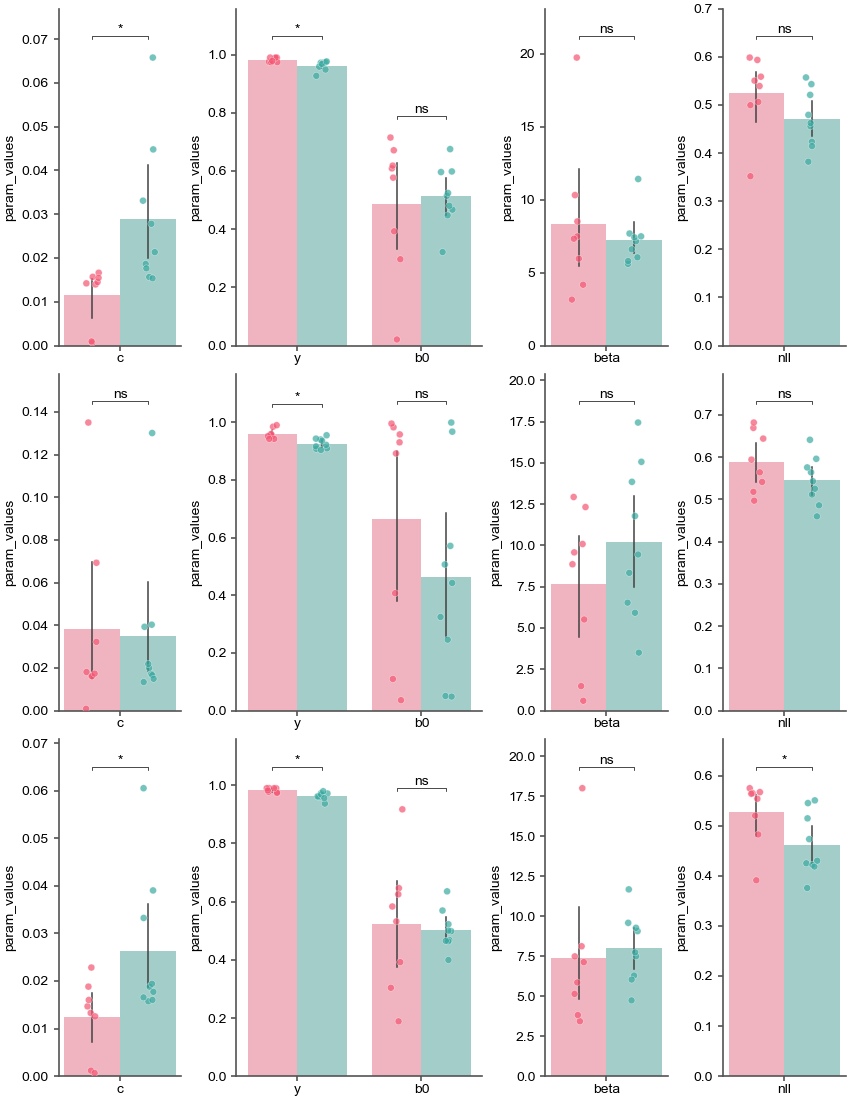

In [9]:
import mab_subjects
import numpy as np
import pandas as pd
from neuropy import plotting
from mab_colors import Palette2Arm
from mab_model_utils import plot_param_block_grid

data_df = mab_subjects.GroupData().fit_si.latest

plot_param_block_grid(data_df=data_df, model_key="si")

### Compare actual vs simulated performance

In [ ]:
import numpy as np
import pandas as pd
from banditpy.models import DecisionModel
from banditpy.models.policy import StateInference2Arm
import mab_subjects
from banditpy.core import mab

exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_struc.allsess
est_params_df = mab_subjects.GroupData().fit_si.latest

perf_df = []

for exp in exps:
    name = exp.sub_name
    print(name)

    task = exp.b2a.filter_by_trials(min_trials=100, clip_max=100)
    task.auto_block_window_ids()

    task_specs = [
        ("block_all", task, task.get_block_start_mask(start=1)),
        (
            "block1",
            task_block1 := task.filter_by_block_id(start=1, stop=1),
            task_block1.get_block_start_mask(start=1, stop=1),
        ),
        (
            "block2_plus",
            task_block2 := task.filter_by_block_id(start=2),
            task_block2.get_block_start_mask(start=2, stop=2),
        ),
    ]

    sims_perf = {}
    for scope, scoped_task, reset_mask in task_specs:
        scope_rows = (est_params_df["name"] == name) & (
            est_params_df["fit_scope"] == scope
        )
        params = dict(
            zip(
                est_params_df.loc[scope_rows, "param_names"],
                est_params_df.loc[scope_rows, "param_values"],
            )
        )
        policy = StateInference2Arm()
        model = DecisionModel(scoped_task, policy=policy, reset_mode=reset_mask)
        model.params = {k: params[k] for k in policy.param_names()}
        sims_perf[scope] = (
            model.simulate_posterior_predictive().get_optimal_choice_probability()
        )

    sub_df = pd.DataFrame(
        {
            "name": name,
            "trial_id": np.arange(100) + 1,
            "perf_all": task.get_optimal_choice_probability(),
            "sim_perf_all": sims_perf["block_all"],
            "perf_block1": task_block1.get_optimal_choice_probability(),
            "sim_perf_block1": sims_perf["block1"],
            "perf_block2plus": task_block2.get_optimal_choice_probability(),
            "sim_perf_block2plus": sims_perf["block2_plus"],
            "grp": exp.group_tag,
        }
    )
    perf_df.append(sub_df)

perf_df = pd.concat(perf_df, ignore_index=True)
mab_subjects.GroupData().save(perf_df, "fit_si_sim")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from neuropy import plotting
import mab_subjects
from mab_colors import Palette2Arm
import numpy as np

fig = plotting.Fig(4, 2, size=(8.5, 11), fontsize=10)

df = mab_subjects.GroupData().fit_si_sim.latest

hue_order = ["unstruc", "struc"]
plot_kw = dict(
    data=df,
    x="trial_id",
    hue="grp",
    hue_order=hue_order,
    palette=Palette2Arm().as_dict(),
    linewidth=1,
    errorbar="se",
    err_kws=dict(edgecolor="none"),
)

for i, block in enumerate(["all", "block1", "block2plus"]):
    ax = fig.subplot(fig.gs[i])
    sns.lineplot(y=f"perf_{block}", ax=ax, linestyle="solid", **plot_kw)
    sns.lineplot(y=f"sim_perf_{block}", ax=ax, linestyle="dashed", **plot_kw)

    ax.set_title(f"{block}: actual vs simulated")
    ax.set_ylabel("P (Optimal choice)")
    ax.set_ylim(0.45, 0.9)
    ax.set_xticks([1, 25, 50, 75, 100])
    # ax.get_legend().remove()
    # ax.legend(['a','b','c','d'])

    ax.legend(["unstruc - actual", "struc - actual", "unstruc - sim", "struc - sim"])

### Comparing switching behavior between actual and simulated

In [ ]:
import numpy as np
import pandas as pd
from banditpy.models import DecisionModel
from banditpy.models.policy import StateInference2Arm
import mab_subjects
from banditpy.core import mab
from banditpy.analyses import SwitchProb2Arm

exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_struc.allsess
est_params_df = mab_subjects.GroupData().fit_si.latest

swp_df = []

for exp in exps:
    name = exp.sub_name
    print(name)

    task = exp.b2a.filter_by_trials(min_trials=100, clip_max=100)
    task.auto_block_window_ids()

    task_specs = [
        ("block_all", task, task.get_block_start_mask(start=1)),
        (
            "block1",
            task_block1 := task.filter_by_block_id(start=1, stop=1),
            task_block1.get_block_start_mask(start=1, stop=1),
        ),
        (
            "block2_plus",
            task_block2 := task.filter_by_block_id(start=2),
            task_block2.get_block_start_mask(start=2, stop=2),
        ),
    ]

    swp = {}
    for scope, scoped_task, reset_mask in task_specs:
        scope_rows = (est_params_df["name"] == name) & (
            est_params_df["fit_scope"] == scope
        )
        params = dict(
            zip(
                est_params_df.loc[scope_rows, "param_names"],
                est_params_df.loc[scope_rows, "param_values"],
            )
        )
        policy = StateInference2Arm()
        model = DecisionModel(scoped_task, policy=policy, reset_mode=reset_mask)
        model.params = {k: params[k] for k in policy.param_names()}
        task_sim = model.simulate_posterior_predictive()

        swp[scope] = SwitchProb2Arm(task_sim).by_trial()

    sub_df = pd.DataFrame(
        {
            "name": name,
            "trial_id": np.arange(99) + 1,
            "switch_prob_all": SwitchProb2Arm(task).by_trial(),
            "sim_switch_prob_all": swp["block_all"],
            "switch_prob_block1": SwitchProb2Arm(task_block1).by_trial(),
            "sim_switch_prob_block1": swp["block1"],
            "switch_prob_block2plus": SwitchProb2Arm(task_block2).by_trial(),
            "sim_switch_prob_block2plus": swp["block2_plus"],
            "grp": exp.group_tag,
        }
    )
    swp_df.append(sub_df)

swp_df = pd.concat(swp_df, ignore_index=True)
mab_subjects.GroupData().save(swp_df, "switchprob_si")

In [ ]:
from neuropy import plotting
from statplotannot.plots import SeabornPlotter
import mab_subjects
from mab_colors import Palette2Arm


df = mab_subjects.GroupData().switchprob_si.latest

fig = plotting.Fig(4, 2, fontsize=10)

for i, block in enumerate(["all", "block1", "block2plus"]):

    ax = fig.subplot(fig.gs[i, 0])
    SeabornPlotter(
        data=df,
        x="trial_id",
        y=f"switch_prob_{block}",
        hue="grp",
        hue_order=["unstruc", "struc"],
        palette=Palette2Arm().as_dict(),
        err_kws=dict(edgecolor="none"),
        ax=ax,
    ).lineplot(linestyle="solid", palette=Palette2Arm().as_dict())

    ax = fig.subplot(fig.gs[i, 1])
    SeabornPlotter(
        data=df,
        x="trial_id",
        y=f"sim_switch_prob_{block}",
        hue="grp",
        hue_order=["unstruc", "struc"],
        palette=Palette2Arm().as_dict(),
        err_kws=dict(edgecolor="none"),
        ax=ax,
    ).lineplot(linestyle="solid", palette=Palette2Arm().as_dict())